In [82]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.model_selection import train_test_split
from skimage import io
import pandas as pd
import os
import matplotlib.pyplot as plt
import pathlib
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import tensorflow_io as tfio

In [2]:
os.chdir('data/Healthcare AI Datasets/Brain_MRI')
os.listdir()

['data.csv',
 'data_mask.csv',
 'resnet-50-MRI.json',
 'ResUNet-MRI.json',
 'TCGA_CS_4941_19960909',
 'TCGA_CS_4942_19970222',
 'TCGA_CS_4943_20000902',
 'TCGA_CS_4944_20010208',
 'TCGA_CS_5393_19990606',
 'TCGA_CS_5395_19981004',
 'TCGA_CS_5396_20010302',
 'TCGA_CS_5397_20010315',
 'TCGA_CS_6186_20000601',
 'TCGA_CS_6188_20010812',
 'TCGA_CS_6290_20000917',
 'TCGA_CS_6665_20010817',
 'TCGA_CS_6666_20011109',
 'TCGA_CS_6667_20011105',
 'TCGA_CS_6668_20011025',
 'TCGA_CS_6669_20020102',
 'TCGA_DU_5849_19950405',
 'TCGA_DU_5851_19950428',
 'TCGA_DU_5852_19950709',
 'TCGA_DU_5853_19950823',
 'TCGA_DU_5854_19951104',
 'TCGA_DU_5855_19951217',
 'TCGA_DU_5871_19941206',
 'TCGA_DU_5872_19950223',
 'TCGA_DU_5874_19950510',
 'TCGA_DU_6399_19830416',
 'TCGA_DU_6400_19830518',
 'TCGA_DU_6401_19831001',
 'TCGA_DU_6404_19850629',
 'TCGA_DU_6405_19851005',
 'TCGA_DU_6407_19860514',
 'TCGA_DU_6408_19860521',
 'TCGA_DU_7008_19830723',
 'TCGA_DU_7010_19860307',
 'TCGA_DU_7013_19860523',
 'TCGA_DU_7014_

In [16]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    if history.history.get('val_loss'):
        plt.plot(history.history['val_loss'], label='val_loss', alpha=0.5)
    plt.yscale('log')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)
    plt.show()

In [3]:
data = pd.read_csv('data_mask.csv')

In [4]:
def balance_data(data):
  data_healthy = data.query('mask == 0')
  data_unhealthy = data.query('mask == 1')

  data_healthy = data_healthy.sample(n=data_unhealthy.shape[0], random_state=2022)

  return pd.concat([data_healthy, data_unhealthy]).sample(frac=1).reset_index()

In [5]:
data = balance_data(data)

In [27]:
data

,index,patient_id,image_path,mask_path,mask
0,1583,TCGA_DU_A5TS_19970726,TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_15...,TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_15...,1
1,2170,TCGA_FG_6691_20020405,TCGA_HT_7693_19950520/TCGA_HT_7693_19950520_20...,TCGA_HT_7693_19950520/TCGA_HT_7693_19950520_20...,0
2,3210,TCGA_HT_8563_19981209,TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_34...,TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_34...,1
3,2558,TCGA_HT_7680_19970202,TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_25...,TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_25...,1
4,3376,TCGA_HT_A61B_19991127,TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_38...,TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_38...,0
...,...,...,...,...,...
2741,1246,TCGA_DU_7008_19830723,TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_12...,TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_12...,0
2742,2420,TCGA_FG_A4MU_20030903,TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_23...,TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_23...,1
2743,2686,TCGA_HT_7856_19950831,TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_26...,TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_26...,1
2744,3121,TCGA_HT_8107_19980708,TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_33...,TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_33...,1


In [43]:
# import shutil
#
# os.chdir('C:\\Users\\tarda\\PycharmProjects\\tum\\data')
#
# for i in data.values:
#     src = 'Healthcare AI Datasets/Brain_MRI/'+i[2]
#
#     print(src)
#     if i[4] == 0:
#         dest = 'tumors/0/'
#         shutil.copy(src, dest)
#     else:
#         dest = 'tumors/1/'
#         shutil.copy(src, dest)

Healthcare AI Datasets/Brain_MRI/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_15.tif
Healthcare AI Datasets/Brain_MRI/TCGA_HT_7693_19950520/TCGA_HT_7693_19950520_20.tif
Healthcare AI Datasets/Brain_MRI/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_34.tif
Healthcare AI Datasets/Brain_MRI/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_25.tif
Healthcare AI Datasets/Brain_MRI/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_38.tif
Healthcare AI Datasets/Brain_MRI/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_39.tif
Healthcare AI Datasets/Brain_MRI/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_28.tif
Healthcare AI Datasets/Brain_MRI/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_29.tif
Healthcare AI Datasets/Brain_MRI/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_41.tif
Healthcare AI Datasets/Brain_MRI/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_49.tif
Healthcare AI Datasets/Brain_MRI/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_6.tif
Healthcare AI Datasets/Brain_MRI/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_

In [70]:
data_dir = pathlib.Path('./tumors/')
batch_size = 32
img_height = 256
img_width = 256

In [71]:
# train_ds = tf.keras.utils.image_dataset_from_directory(
#   data_dir,
#   validation_split=0.2,
#   subset="training",
#   seed=123,
#   image_size=(img_height, img_width),
#   batch_size=batch_size)

In [72]:
image_count = len(list(data_dir.glob('*/*.tif')))
print(image_count)

2746


In [97]:
list_ds = tf.data.Dataset.list_files(f'{data_dir}/*/*', shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [98]:
for f in list_ds.take(5):
  print(f.numpy())

b'tumors\\1\\TCGA_DU_5849_19950405_26.tif'
b'tumors\\0\\TCGA_CS_5397_20010315_20.tif'
b'tumors\\1\\TCGA_DU_7306_19930512_20.tif'
b'tumors\\1\\TCGA_DU_6408_19860521_22.tif'
b'tumors\\0\\TCGA_FG_A4MU_20030903_36.tif'


In [99]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['0' '1']


In [100]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2197
549


In [101]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [102]:
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tfio.experimental.image.decode_tiff(img)
  # Resize the image to the desired size
  # todo: quitar resize
  return tf.image.resize(img, [img_height, img_width])
  # return img

In [103]:
def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [104]:
from tensorflow.python.data import AUTOTUNE

# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [105]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (256, 256, 4)
Label:  0


In [106]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

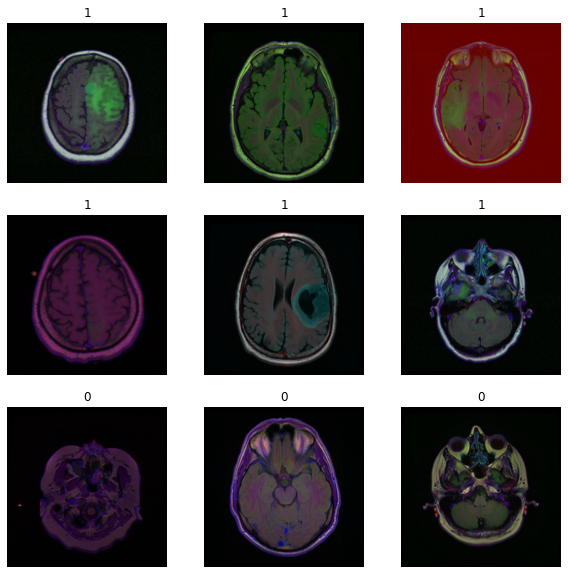

In [107]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

Hay que normalizar problablemente

In [112]:
num_classes = len(class_names)
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 4)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [113]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [114]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 256, 256, 4)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 256, 256, 16)      592       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 64)      

In [115]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
69/69 [==============================] - 87s 1s/step - loss: 0.6212 - accuracy: 0.7128 - val_loss: 0.4398 - val_accuracy: 0.8233
Epoch 2/10
69/69 [==============================] - 76s 1s/step - loss: 0.4459 - accuracy: 0.7975 - val_loss: 0.4131 - val_accuracy: 0.8160
Epoch 3/10
69/69 [==============================] - 81s 1s/step - loss: 0.4059 - accuracy: 0.8179 - val_loss: 0.4502 - val_accuracy: 0.7887
Epoch 4/10
69/69 [==============================] - 75s 1s/step - loss: 0.3595 - accuracy: 0.8339 - val_loss: 0.3330 - val_accuracy: 0.8434
Epoch 5/10
69/69 [==============================] - 73s 1s/step - loss: 0.3244 - accuracy: 0.8521 - val_loss: 0.3242 - val_accuracy: 0.8597
Epoch 6/10
69/69 [==============================] - 79s 1s/step - loss: 0.2930 - accuracy: 0.8671 - val_loss: 0.3073 - val_accuracy: 0.8616
Epoch 7/10
69/69 [==============================] - 76s 1s/step - loss: 0.2357 - accuracy: 0.8999 - val_loss: 0.3768 - val_accuracy: 0.8251
Epoch 8/10
69/69 [==

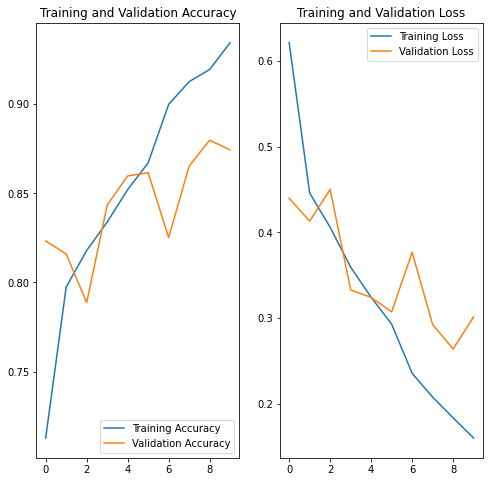

In [116]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
def model300():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(256, 256, 3)))
    model.add(tf.keras.layers.Dense(1000, activation=tf.nn.relu))
    model.add(tf.keras.layers.Dropout(.2))
    model.add(tf.keras.layers.Dense(250, activation=tf.nn.relu))
    model.add(tf.keras.layers.Dropout(.2))
    model.add(tf.keras.layers.Dense(100, activation=tf.nn.relu))
    return model


def nn():
    reduce_lr_cb = tf.keras.callbacks.ReduceLROnPlateau(patience=5)
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10)

    model = model300()

    model.add(tf.keras.layers.Dense(2, activation=tf.nn.softmax))
    model.compile(optimizer=tf.optimizers.Adam(),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(train_ds, validation_data=val_ds, epochs=200, validation_split=0.2,
                          callbacks=[reduce_lr_cb, early_stopping_cb])

    val_loss, val_acc = model.evaluate(train_ds)
    plot_loss(history)
    print('Validation loss: ', val_loss)
    print('Accuracy: ', round(val_acc, 2))


nn()

Epoch 1/200
55/55 [==============================] - 73s 1s/step - loss: 1152.6882 - accuracy: 0.5752 - val_loss: 270.6547 - val_accuracy: 0.6477 - lr: 0.0010
Epoch 2/200
55/55 [==============================] - 83s 2s/step - loss: 350.1064 - accuracy: 0.6110 - val_loss: 84.1790 - val_accuracy: 0.7432 - lr: 0.0010
Epoch 3/200
55/55 [==============================] - 83s 2s/step - loss: 125.3173 - accuracy: 0.6475 - val_loss: 60.6474 - val_accuracy: 0.6818 - lr: 0.0010
Epoch 4/200
55/55 [==============================] - 77s 1s/step - loss: 89.1739 - accuracy: 0.6595 - val_loss: 28.1056 - val_accuracy: 0.7727 - lr: 0.0010
Epoch 5/200
55/55 [==============================] - 71s 1s/step - loss: 57.6693 - accuracy: 0.6708 - val_loss: 34.2687 - val_accuracy: 0.6705 - lr: 0.0010
Epoch 6/200
55/55 [==============================] - 86s 2s/step - loss: 52.4273 - accuracy: 0.6800 - val_loss: 31.9871 - val_accuracy: 0.6932 - lr: 0.0010
Epoch 7/200
55/55 [==============================] - 77s 1s

KeyboardInterrupt: 

In [ ]:
X_train.shape

In [ ]:
# from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
#
# model = ResNet50(input_shape=(256,256,3),include_top=False)
#
# model.compile(optimizer=tf.optimizers.Adam(),
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])
#
# history = model.fit(X_train, y_train, epochs=5, validation_split=0.2)
#
# val_loss, val_acc = model.evaluate(X_test, y_test)